In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('dark_background')

In [2]:
df = pd.read_csv('PJME_hourly.csv')

In [3]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [5]:
df = df.set_index('Datetime')

In [6]:
sns.color_palette()

[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (0.996078431372549, 1.0, 0.7019607843137254),
 (0.7490196078431373, 0.7333333333333333, 0.8509803921568627),
 (0.9803921568627451, 0.5058823529411764, 0.4549019607843137),
 (0.5058823529411764, 0.6941176470588235, 0.8235294117647058),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
 (0.7372549019607844, 0.5098039215686274, 0.7411764705882353),
 (0.8, 0.9215686274509803, 0.7686274509803922),
 (1.0, 0.9294117647058824, 0.43529411764705883)]

<Axes: title={'center': 'PJME energy used in MW'}, xlabel='Datetime'>

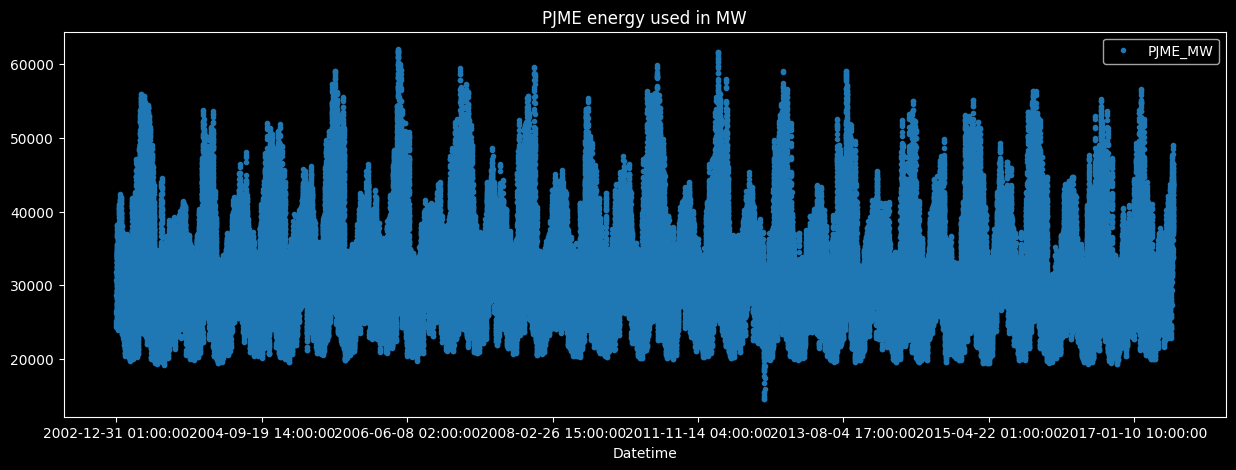

In [7]:
df.plot(style='.',
        figsize=(15,5),
        color=color_pal[0],
        title='PJME energy used in MW')

In [8]:
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

In [9]:
pd.to_datetime(df.index)

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

In [10]:
df.index = pd.to_datetime(df.index)

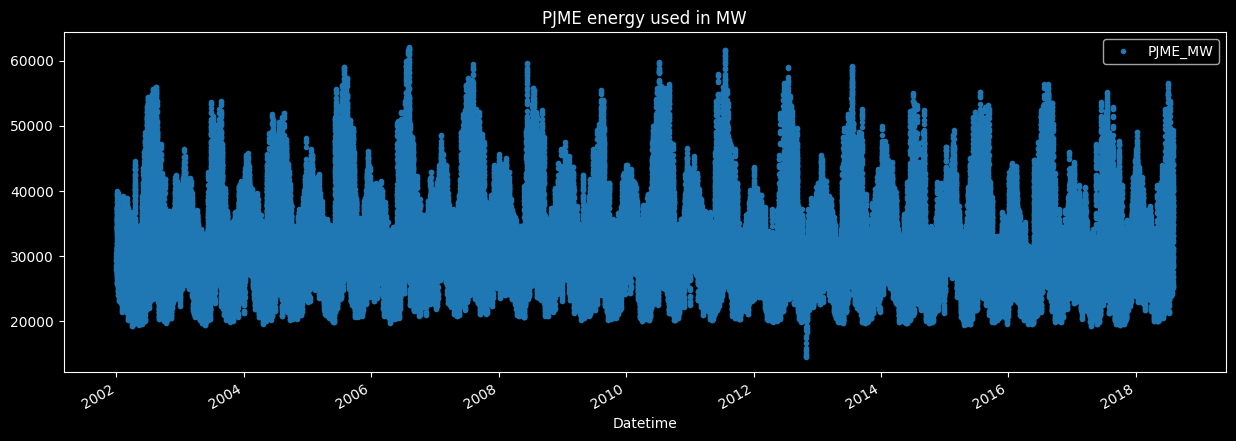

In [11]:
df.plot(style='.',
        figsize=(15,5),
        color=color_pal[0],
        title='PJME energy used in MW')

plt.show()

# Train and test data

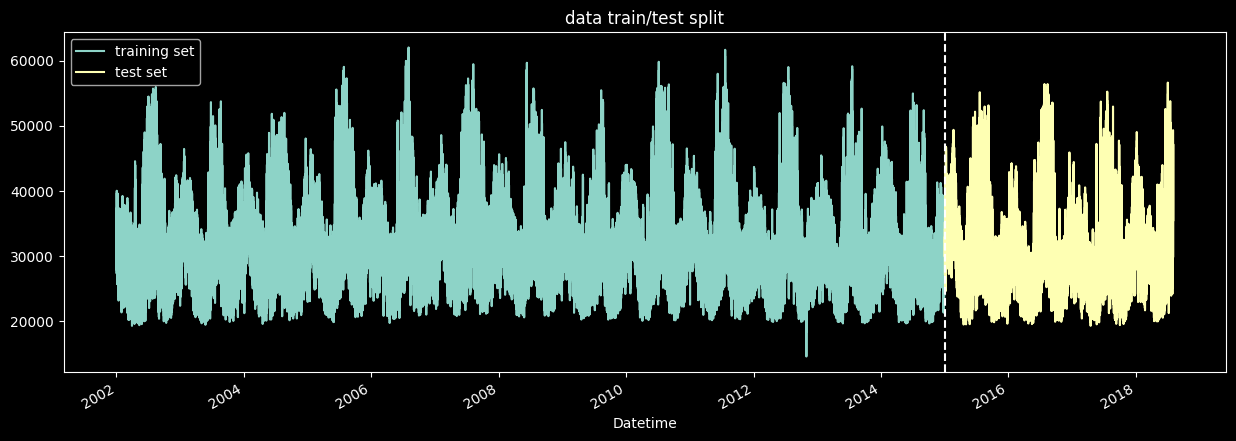

In [12]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='taining set', title='data train/test split')
test.plot(ax=ax, label='test set')
ax.axvline('01-01-2015', color='white', ls='--')
ax.legend(['training set', 'test set'])
fig.show()

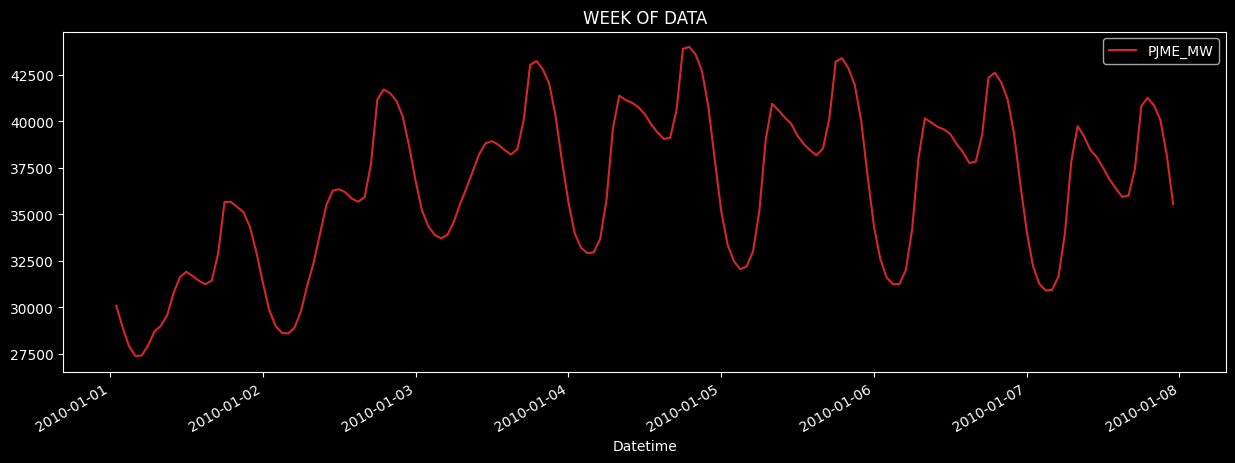

In [13]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5),
                                                                   color=color_pal[3],
                                                                   title='WEEK OF DATA'
                                                                  )

plt.show()

# Feature creation

In [14]:
def create_feature(df):
  """create time series feature based on time series index
  """
  df = df.copy()
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  df['dayofmonth'] = df.index.day
  df['weekofyear'] = df.index.isocalendar().week

  return df

In [15]:
df = create_feature(df)

In [16]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


# Visualise feature/target relationship

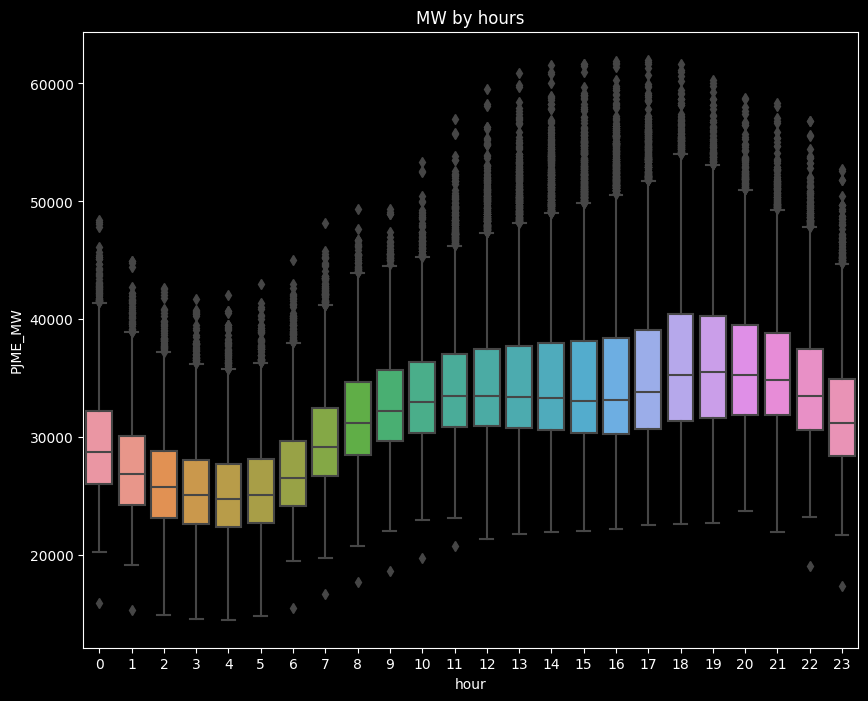

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by hours')
plt.show()

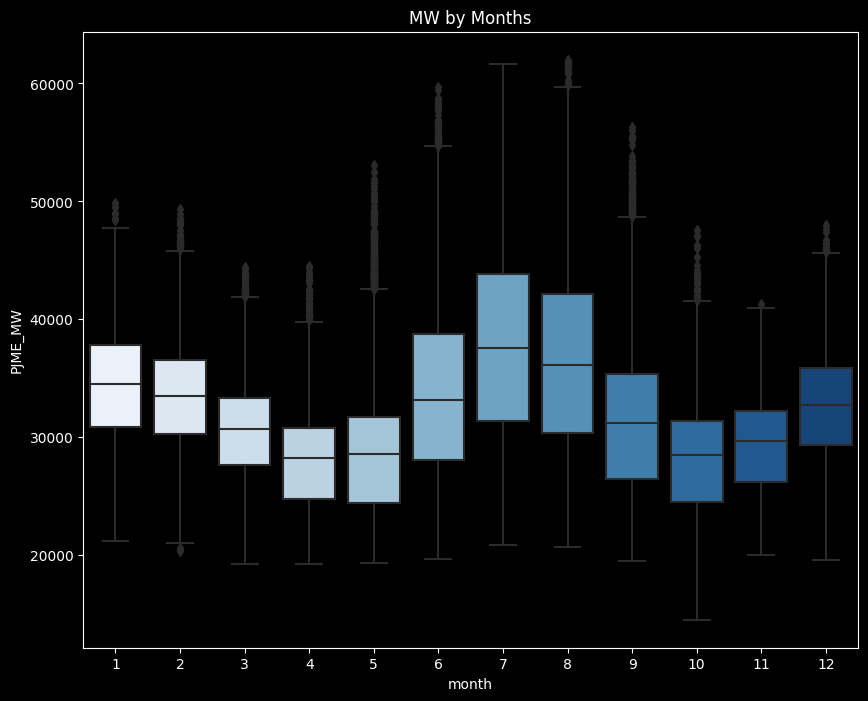

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Months')
plt.show()

# Create the model

In [19]:
 train = create_feature(train)
 test = create_feature(test)

In [20]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')

In [21]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

In [22]:
X_train = train[FEATURES]
y_train  = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [23]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose = 100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.83677
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.99037
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.30897


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Feature importance

In [24]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index = reg.feature_names_in_,
                  columns = ['importance']
                 )

In [25]:
fi.head()

,importance
dayofyear,0.115098
hour,0.455198
dayofweek,0.162696
quarter,0.028019
month,0.215611


<Axes: title={'center': 'Feature Importance'}>

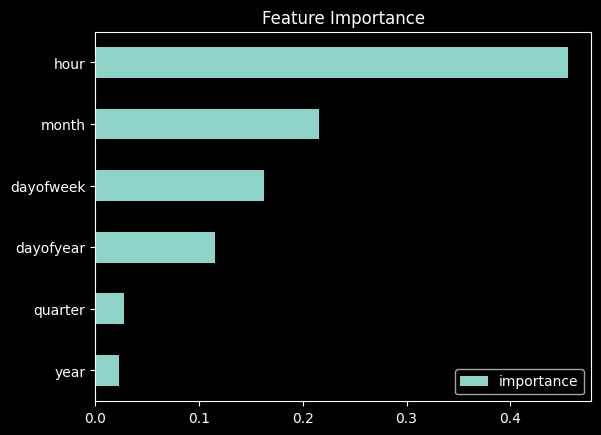

In [26]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

# Forecast on test

In [27]:
reg.predict(X_test)

array([32393.352, 29040.168, 27877.018, ..., 36229.527, 35141.754,
       32339.713], dtype=float32)

In [35]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

<ipython-input-36-f716696e5b04>:3: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Truth Data', 'Predictions')


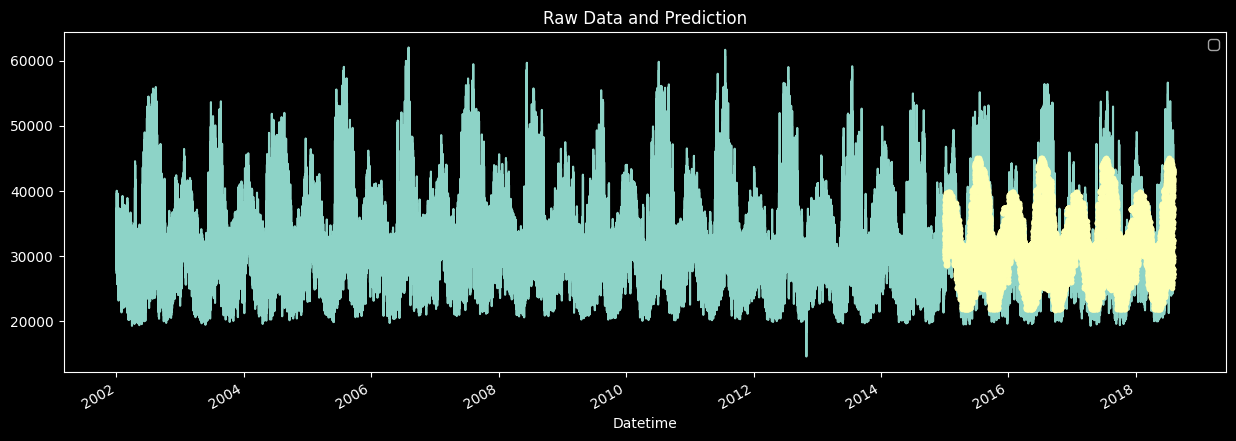

In [36]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend('Truth Data', 'Predictions')
ax.set_title('Raw Data and Prediction')
plt.show()

<ipython-input-38-ecf1c31c999c>:7: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Truth Data' , 'Prediction')


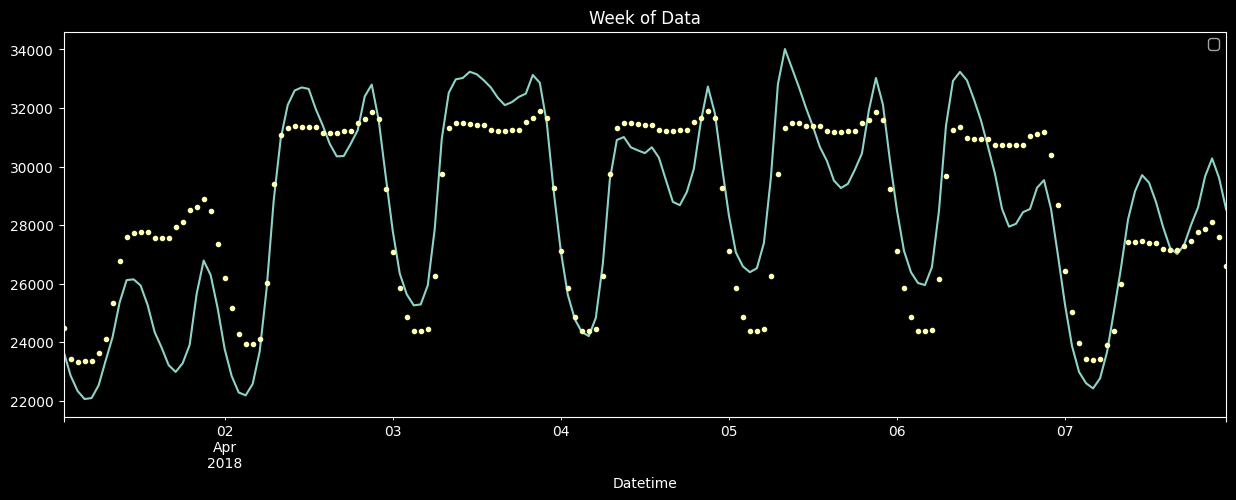

In [38]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15,5), title='Week of Data')

df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction']\
    .plot(style='.')

plt.legend('Truth Data' , 'Prediction')
plt.show()

# Score (RMSE)

In [39]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3741.16


# Calculate error
look at the worst and best days

In [41]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
2018-01-06    10407.698161
2015-02-20    10143.611491
2017-05-19     9495.122640
2016-07-04     9440.610596
2016-07-23     9362.332682
Name: error, dtype: float64

In [42]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2016-12-30    395.436442
2017-10-24    413.885824
2016-10-27    440.053141
2016-04-04    440.223877
2017-05-02    453.738688
2015-10-28    459.086426
2016-06-03    467.453532
2018-02-06    477.327718
2016-08-08    496.441406
2016-12-12    553.641357
Name: error, dtype: float64